In [146]:
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np
import cv2
import os

In [147]:
FILENAME = "test_corner.mp4"
MAX_FRAMES = 1000
INTERVAL = 50
MAX_MATCH_DISTANCE = 200

In [148]:
def extract_keypoints(video):
    # Create a VideoCapture object to read the video file
    cap = cv2.VideoCapture(video)
    # Create an ORB object
    orb = cv2.ORB_create()
    # Extract all keypoints and descriptors by frame
    frame_kpt, frame_des = [], []
    video_frames = []
    k = 1
    # Loop through the video frames
    with tqdm(total=MAX_FRAMES) as pbar:
        while cap.isOpened() and k <= MAX_FRAMES:
            # Read a frame from the video
            ret, frame = cap.read()
            # Check if the frame was successfully read
            if not ret:
                continue
            gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
            kpt, des = orb.detectAndCompute(gray, None)
            if des is None:
                print("No keypoints/descriptors in frame ", k)
                continue
            pbar.update(1)
            frame_kpt.append(kpt)
            frame_des.append(des)
            video_frames.append(frame)
            k += 1
            # Wait for Esc key to stop
            if cv2.waitKey(1) == 27:
                # De-allocate any associated memory usage
                cv2.destroyAllWindows()
                cap.release()
                break
        cap.release()
        return frame_kpt, frame_des, video_frames


def compute_all_matches(frame_des, frame_kpt):
    # Create a Brute Force Matcher object
    bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
    # Compute all matches
    all_matches = []
    matched_keypoints = []
    matched_descriptors = []
    for i in range(len(frame_des) - 1):
        matches = bf.match(frame_des[i], frame_des[i + 1])
        matches = [match for match in matches if match.distance < MAX_MATCH_DISTANCE]
        paired_matches = [(match.queryIdx, match.trainIdx) for match in matches]
        all_matches.append(paired_matches)
        # Get matched keypoints
        matched_keypoints.append([[frame_kpt[i][match.queryIdx] for match in matches]])
        matched_descriptors.append(
            [[frame_des[i][match.queryIdx] for match in matches]]
        )
    if i == len(frame_des) - 2:
        matched_keypoints.append(
            [[frame_kpt[i + 1][match.trainIdx] for match in matches]]
        )
        matched_descriptors.append(
            [[frame_des[i + 1][match.trainIdx] for match in matches]]
        )
    return all_matches


frame_kpt, frame_des, video_frames = extract_keypoints(FILENAME)
all_matches = []
for i in tqdm(range(0, len(frame_kpt), INTERVAL)):
    all_matches.append(
        compute_all_matches(frame_des[0 + i : INTERVAL + i], frame_kpt[0 + i : INTERVAL + i])
    )

100%|██████████| 20/20 [00:00<00:00, 24.64it/s]


In [149]:
def compare_matches(all_matches: np.ndarray) -> np.ndarray:
    # List to store the continuous matches and the terminal matches
    continues_keypoints = []
    terminated_keypoints = []
    # Extract pairs of matching keypoints' indices from the matches
    for i, matches in enumerate(all_matches):
        if not matches:
            continue
        # Extract the indices of the matching keypoints
        match_pair_1, match_pair_2 = zip(*matches)
        # Extract the indices of the matching keypoints from the last interval
        last_matches = [x[0][-1] for x in continues_keypoints]
        for j in range(500):
            if j in match_pair_1:
                if j in last_matches:
                    index = last_matches.index(j)
                    continues_keypoints[index][0].append(
                        match_pair_2[match_pair_1.index(j)]
                    )
                    continues_keypoints[index][2] = i + 2
                else:
                    continues_keypoints.append(
                        [[j, match_pair_2[match_pair_1.index(j)]], i + 1, i + 2]
                    )
            else:
                if j in last_matches:
                    terminated_keypoints.append(
                        continues_keypoints[last_matches.index(j)]
                    )

        # Remove the keypoints in consecutive matches that has terminated
        continues_keypoints = [
            x for x in continues_keypoints if x not in terminated_keypoints
        ]
    terminated_keypoints.extend(continues_keypoints)

    # Remove the keypoints that are not continuous
    terminated_keypoints = [x for x in terminated_keypoints if len(x[0]) == INTERVAL]
    return terminated_keypoints


debug_data = [
    [(1, 3), (2, 4), (3, 5), (5, 9)],
    [(3, 4), (4, 5), (8, 9)],
    [(1, 2), (2, 3), (4, 5), (5, 6)],
    [(2, 4), (4, 5), (5, 6), (6, 7)],
    [(1, 1), (2, 3), (3, 5), (4, 6), (6, 9)],
]

terminated_keypoints_list = [[] for i in range(len(all_matches))]
for i in range(len(all_matches)):
    terminated_keypoints = compare_matches(all_matches[i])
    for tk in terminated_keypoints:
        terminated_keypoints_list[i].append(tk[0])

In [150]:
total_keypoint_trace = []
for idx, tk in enumerate(terminated_keypoints_list):
    keypoint_trace = []
    # Extract the keypoints positions
    for kpts in tk:
        current_keypoint_trace = []
        for i in range(INTERVAL):
            # print(frame_kpt[i][kpts[i]].pt)
            current_keypoint_trace.append(frame_kpt[idx * INTERVAL + i][kpts[i]].pt)
        keypoint_trace.append(current_keypoint_trace)
    print("Number of traces: ", len(keypoint_trace))
    total_keypoint_trace.append(keypoint_trace)

Number of traces:  16
Number of traces:  19
Number of traces:  50
Number of traces:  35
Number of traces:  25
Number of traces:  16
Number of traces:  60
Number of traces:  30
Number of traces:  38
Number of traces:  21
Number of traces:  34
Number of traces:  36
Number of traces:  29
Number of traces:  27
Number of traces:  31
Number of traces:  24
Number of traces:  46
Number of traces:  25
Number of traces:  34
Number of traces:  16


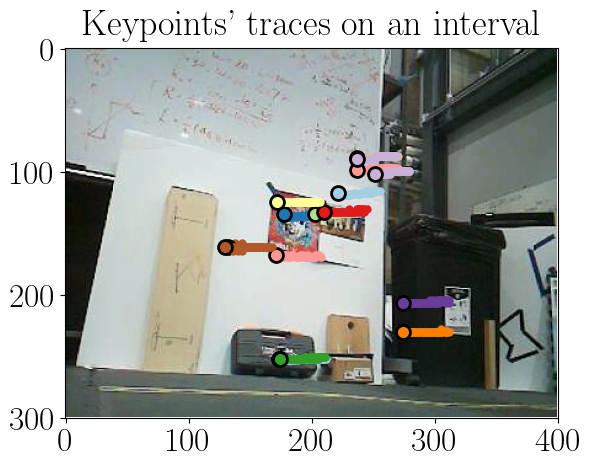

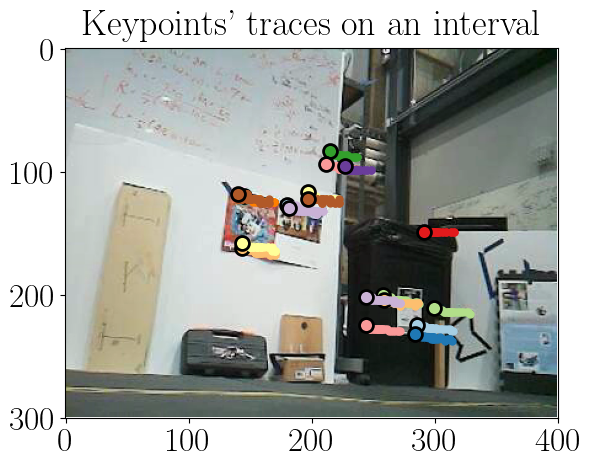

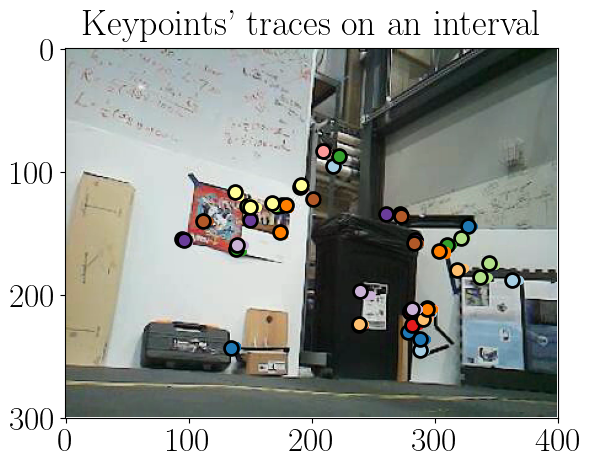

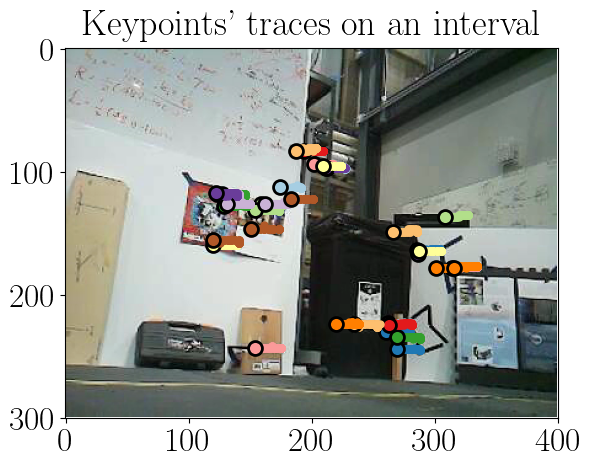

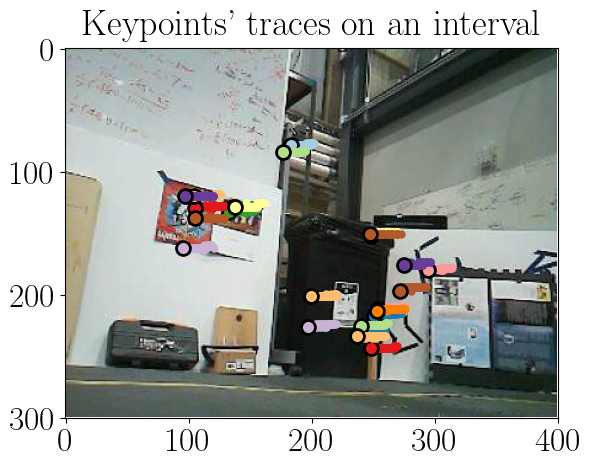

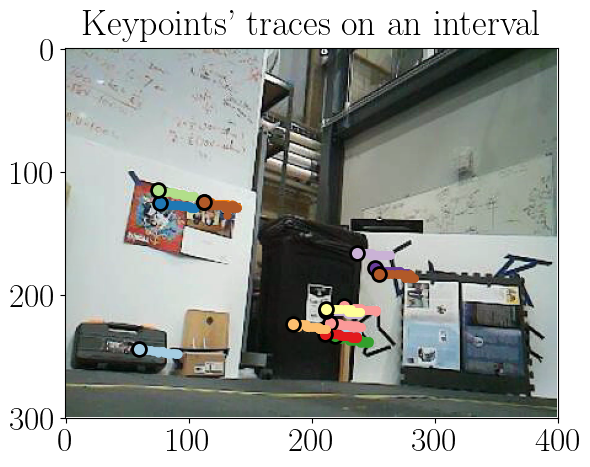

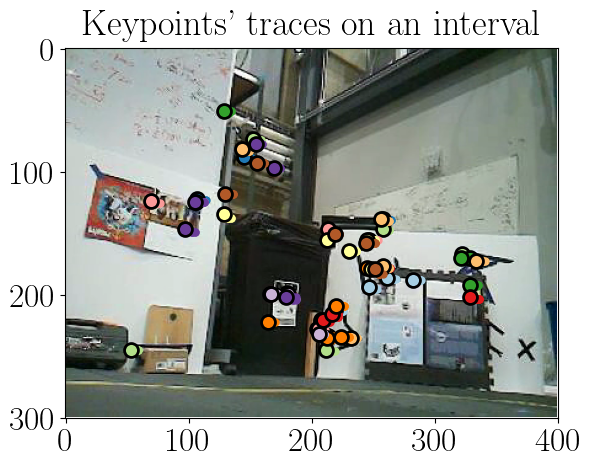

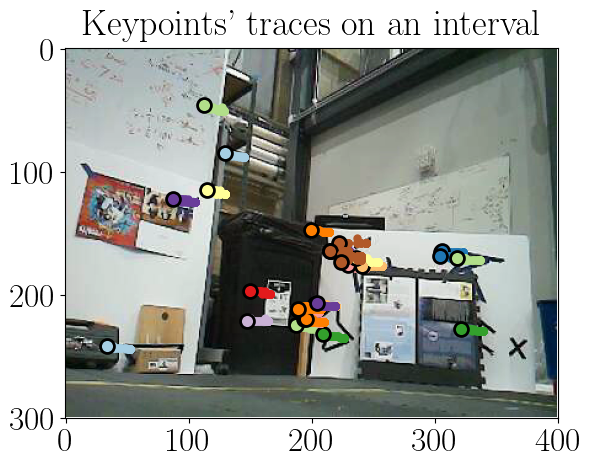

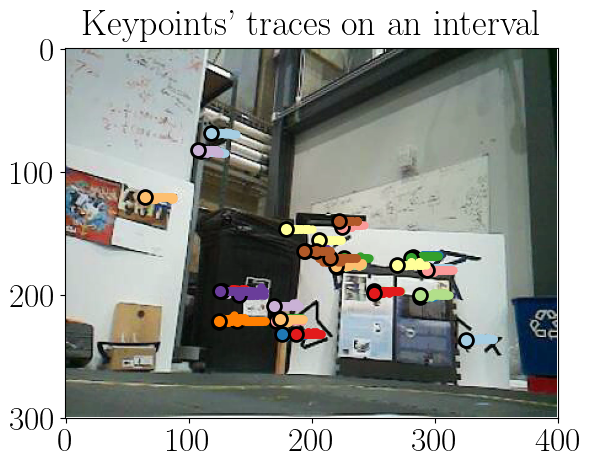

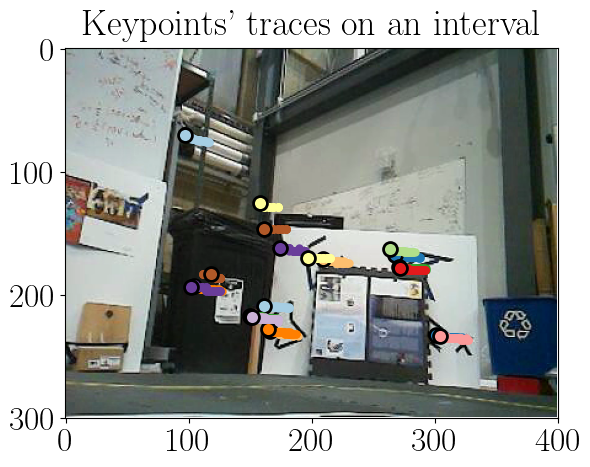

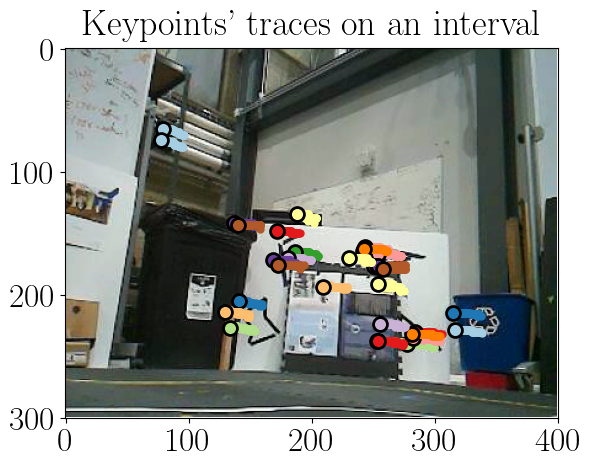

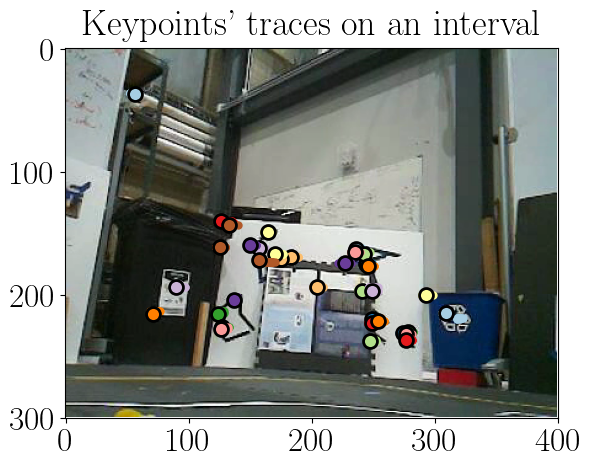

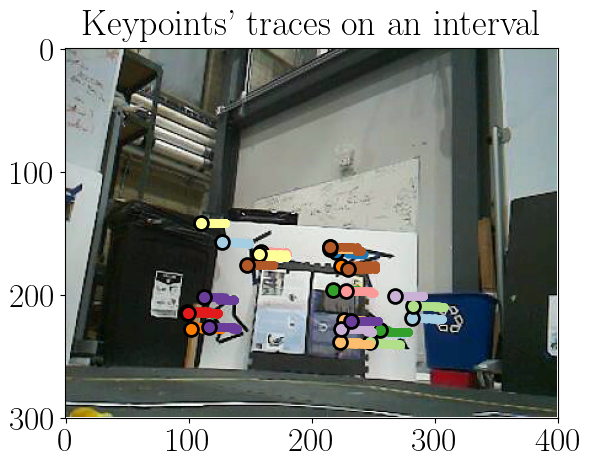

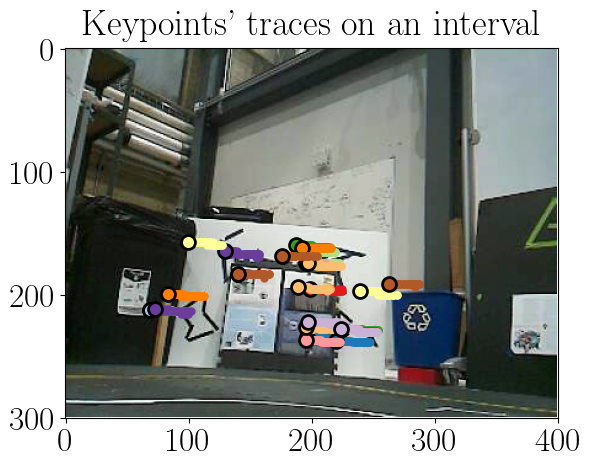

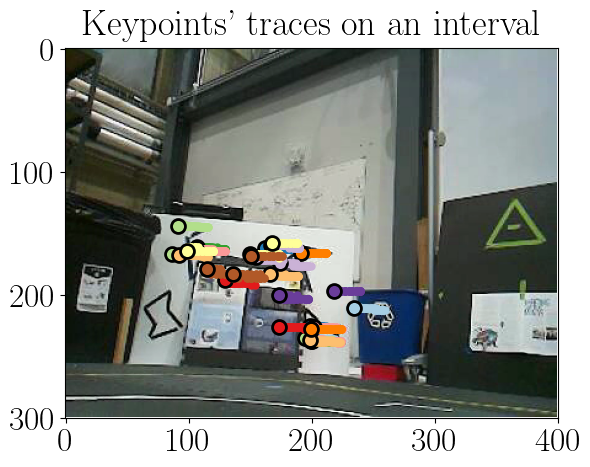

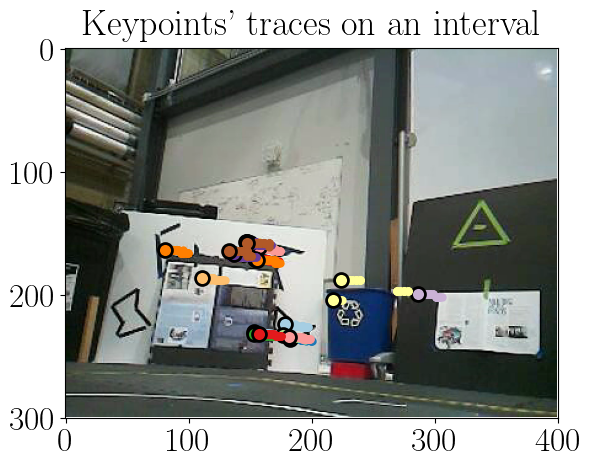

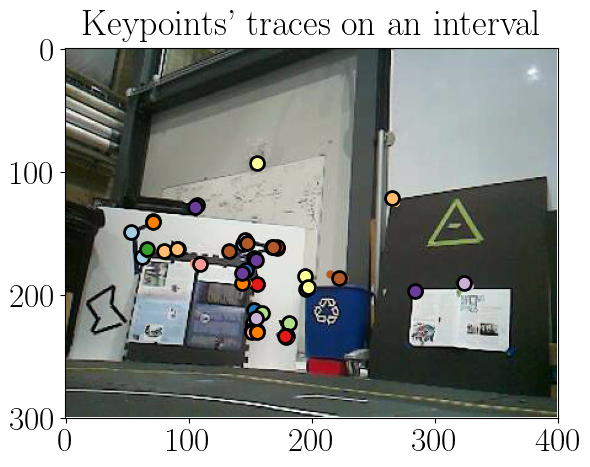

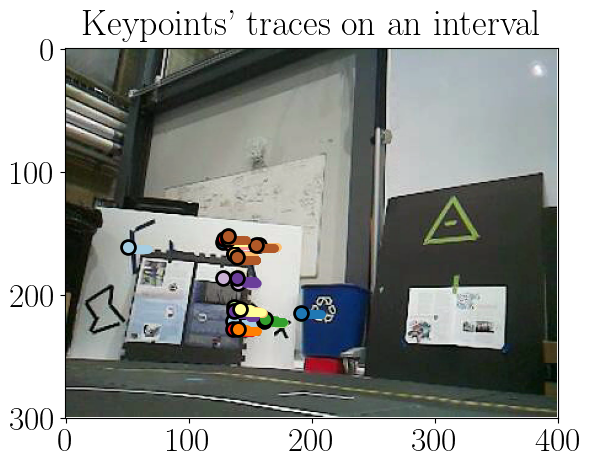

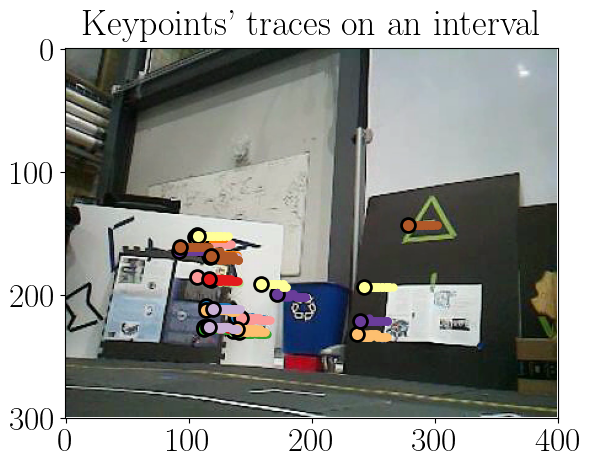

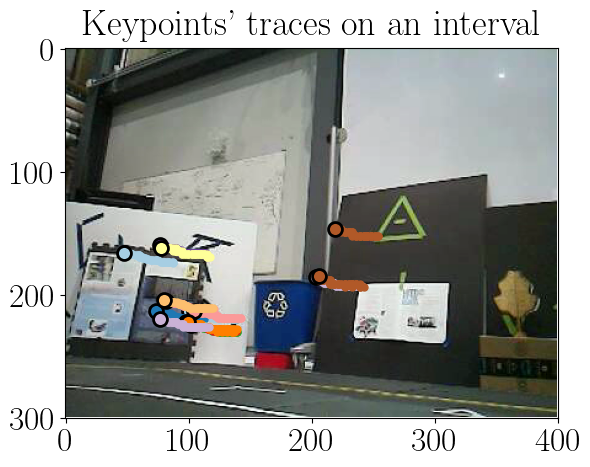

In [151]:
def plot_keypoints_traces(frame, total_kpts, index):
    plt.rc("font", family = "serif")
    plt.rc("text", usetex = True)
    plt.rc("xtick", labelsize = 24)
    plt.rc("ytick", labelsize = 24)
    plt.rc("legend", fontsize = 18)
    plt.rc("axes", titlesize = 26)
    plt.rc("axes", labelsize = 32)
    plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
    
    # Use a colormap to generate distinct colors
    cmap = plt.get_cmap('Paired')
    colors = cmap(np.linspace(0, 1, len(total_kpts)))
    
    for idx, tk in enumerate(total_kpts):
        color = colors[idx]
        for kpt_idx, kpt in enumerate(tk):
            if kpt_idx == INTERVAL - 1:  # first keypoint
                plt.plot(kpt[0], kpt[1], "o", markerfacecolor=color, markersize=10, 
                         markeredgecolor="black", markeredgewidth=2)
            else:
                plt.plot(kpt[0], kpt[1], "o", color=color, markersize=5)
    plt.xticks(np.arange(0, 401, 100))
    plt.yticks(np.arange(0, 301, 100))
    plt.title("Keypoints' traces on an interval", pad=10)
    plt.savefig("keypoints_trace_{}.pdf".format(index), bbox_inches="tight")
    plt.show()

# Sample Usage:
for i in range(MAX_FRAMES // INTERVAL):
    plot_keypoints_traces(video_frames[i*INTERVAL], total_keypoint_trace[i], i)